<a href="https://colab.research.google.com/github/nicolycosta/RedesNeurais-SeriesTemporais/blob/main/RNIPCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Em andamento ..

In [1]:
#Webscrapping
!mkdir downloads #cria uma pasta chamada downloads
import ssl #necessário para o MDIC, erro caso acessar sem certificados
import urllib.request #necessário para downloads

#neuralprophet
!pip install neuralprophet[live]
from neuralprophet import NeuralProphet

#Análise e exploração de dados
!pip install xlrd==1.2.0
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

     |████████████████████████████████| 74 kB 1.7 MB/s 
     |████████████████████████████████| 172 kB 45.3 MB/s 
     |████████████████████████████████| 793 kB 49.2 MB/s 
     |████████████████████████████████| 792 kB 38.3 MB/s 
     |████████████████████████████████| 792 kB 35.7 MB/s 
     |████████████████████████████████| 791 kB 56.5 MB/s 
     |████████████████████████████████| 790 kB 52.1 MB/s 
     |████████████████████████████████| 788 kB 44.3 MB/s 
     |████████████████████████████████| 787 kB 70.9 MB/s 
     |████████████████████████████████| 786 kB 41.3 MB/s 
     |████████████████████████████████| 786 kB 43.1 MB/s 
     |████████████████████████████████| 785 kB 46.1 MB/s 
     |████████████████████████████████| 785 kB 43.3 MB/s 
     |████████████████████████████████| 785 kB 37.8 MB/s 
     |████████████████████████████████| 785 kB 44.1 MB/s 
     |████████████████████████████████| 785 kB 41.0 MB/s 
     |████████████████████████████████| 784 kB 47.0 MB/s 
     |██████████

Como os dados são extraídos diretamente da internet, prestar atenção na atualização dos meses!

In [2]:
#Download do Consumo comercial de energia elétrica no estado do Pará

ssl._create_default_https_context = ssl._create_unverified_context #certificado
filenamepath = 'downloads/energia.xlsx' 
link = 'https://www.epe.gov.br/sites-pt/publicacoes-dados-abertos/publicacoes/PublicacoesArquivos/publicacao-190/CONSUMO%20MENSAL%20DE%20ENERGIA%20EL%C3%89TRICA%20POR%20CLASSE.xls'
urllib.request.urlretrieve(link, filenamepath) #baixando no Arquivos
df = pd.read_excel(filenamepath, sheet_name = 'CONSUMO COMERCIAL POR UF')

In [5]:
# Tratamento de dados
df = df.iloc[3:,:] #retirando linhas
df = df.T #transpondo
df[3] = df[3].fillna(method="ffill")
df[3][0]= "Ano" 
df[4][0]= "Mes" 
df.columns = df.iloc[0]
df = df.reset_index(drop = True)
df.drop([0], inplace = True)
df = df.reset_index(drop = True)

In [7]:
lista = []
for item in df["Ano"].unique():
  lista.append(range(1,13))   # para cada ano que tem no dataframe ele conta de 1 até 12, e appenda na lista
  #for each year in the dataframe, it counts from one to twelve and appends it to the lista
listao = []
for item in lista:
  for subitem in item:
    listao.append(subitem)#desempacota as listas dentro das listas
    #get each item inside each list inside the lista variable and appends it to listao
listao = listao[:len(df)] #corta os meses que não tem, limitando baseado no tamanho do dataframe.
mesnew = []
for item in listao:
  mesnew.append(f"{item:02}") #mudando o formato para string e padronizando para dois digitos.
df['Mes'] = mesnew
df['Ano'] = df['Ano'].astype(str).str.replace('*','')  #converte a coluna para string, para usar o comando replace de strings, visto que a coluna tinha dtypes misturados
df['data'] = df['Ano'] + df['Mes']
df.drop(columns = ['Ano', 'Mes'], inplace = True)
df = df.set_index('data')
df = df.iloc[:,:-1]
df = df.dropna(axis=0)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  from ipykernel import kernelapp as app



In [9]:
df['Pará']

data
200401     78075.21
200402     72466.75
200403     75856.86
200404     78778.78
200405      79714.3
            ...    
202108    181711.98
202109    177392.31
202110    180006.38
202111       176108
202112       181856
Name: Pará, Length: 216, dtype: object

# **Pré Processamento**

In [4]:
df = pd.read_excel("Variação0.xlsx")
s = df.iloc[:,0:1]
s.insert(1, "energia", df['Consumo Comercial'], allow_duplicates=False)
s= s.dropna()
serie = s
serie['Mês'] = pd.to_datetime(serie['Mês']) 
serie = serie.set_index('Mês')
serie

FileNotFoundError: ignored

# **Análise Exploratória**

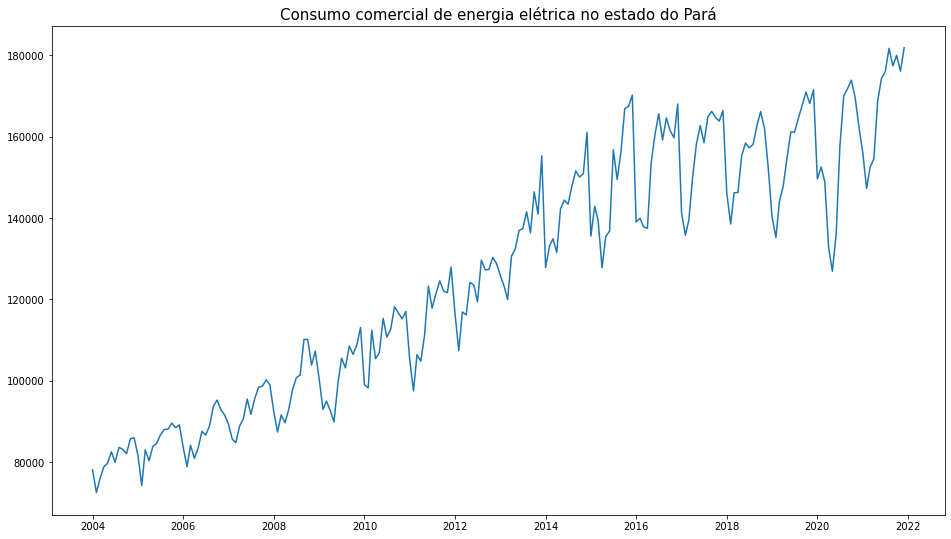

In [ ]:
plt.figure(figsize=(16,9))

plt.plot()
plt.plot(serie['energia'])
plt.title('Consumo comercial de energia elétrica no estado do Pará',fontsize=15)
plt.ylabel('',fontsize=14)
#plt.savefig('Gráfico.png', format='png') #salvar o imagem

plt.show()

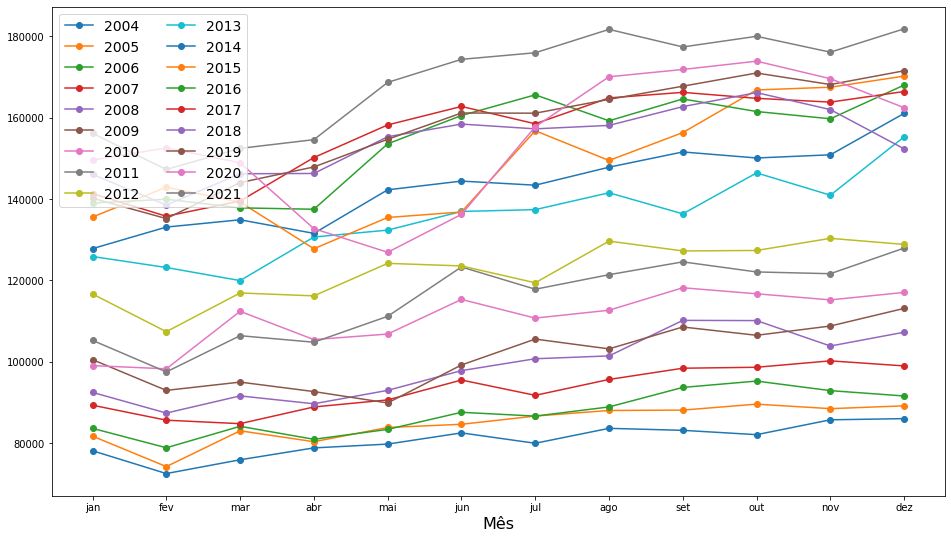

In [ ]:
anos = serie.index.year.unique()
meses = serie.index.month.unique()
mesesStr = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']

plt.figure(figsize = (16,9))

for i in anos:
    ZtAno = serie[(serie.index.year == i)]
    nMeses = len(ZtAno)
    plt.plot(mesesStr[0:nMeses], ZtAno, 'o-', label = str(i))

plt.xlabel('Mês',fontsize=16)
plt.legend(loc = 'upper left', prop = {'size': 14}, ncol = 2)

plt.show()

# **Separação em treino e teste**

In [ ]:
# NeuralProbhet espera uma coluna ds e uma y.
serieNova = s
serieNova.columns = ['ds', 'y']
serieNova 

,ds,y
0,2004-01-01,78075.21
1,2004-02-01,72466.75
2,2004-03-01,75856.86
3,2004-04-01,78778.78
4,2004-05-01,79714.30
...,...,...
211,2021-08-01,181711.98
212,2021-09-01,177392.31
213,2021-10-01,180006.38
214,2021-11-01,176108.00


In [ ]:
nSamples = len(serieNova) 
nTestSamples = 12     
nModelSamples = nSamples - nTestSamples

print(f'Número de amostras: {nSamples}')
print(f'Número de amostras para treino: {nModelSamples}')
print(f'Número de amostras para teste: {nTestSamples}')

Train = serieNova.iloc[:nModelSamples]
Test = serieNova.iloc[nModelSamples:]


Número de amostras: 216
Número de amostras para treino: 204
Número de amostras para teste: 12


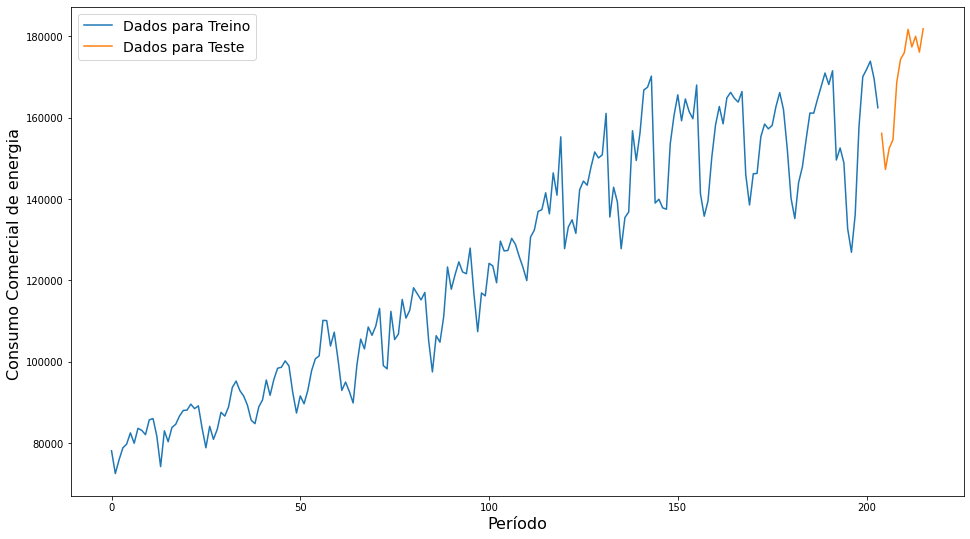

In [ ]:
plt.figure(figsize = (16, 9))

plt.plot(Train['y'], label = 'Dados para Treino')
plt.plot(Test['y'], label = 'Dados para Teste')
plt.legend(loc = 'upper left', prop = {'size': 14})
plt.xlabel('Período',fontsize=16)
plt.ylabel('Consumo Comercial de energia ',fontsize=16)

plt.show()


# **NeuralProphet**
#### NeuralProphet é uma versão atualizada do Prophet
Usando o mecanismo de otimização Gradient Descent do PyTorch

In [ ]:
modeladd = NeuralProphet(seasonality_mode="additive",
                      epochs= 600)
modelmul = NeuralProphet(seasonality_mode="multiplicative",
                      epochs= 600)

# **Teste** 

In [ ]:
modeladd.fit(Train, freq= 'M')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.176% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 1.65E+00


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E-01, min: 2.11E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.00E-01
Epoch[600/600]: 100%|██████████| 600/600 [00:18<00:00, 33.04it/s, SmoothL1Loss=0.00156, MAE=4.04e+3, RMSE=5.18e+3, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.884767,125698.548407,148497.856924,0.0
1,0.859661,123098.091912,145873.329044,0.0
2,0.834878,120521.066636,142826.601103,0.0
3,0.808675,117781.629749,140106.398284,0.0
4,0.782697,115034.834712,137221.310202,0.0
...,...,...,...,...
595,0.001562,4044.162995,5171.016965,0.0
596,0.001562,4044.199721,5161.797727,0.0
597,0.001562,4043.933747,5206.006855,0.0
598,0.001562,4043.841830,5193.697237,0.0


In [ ]:
modelmul.fit(Train, freq= 'M')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.176% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.88E+00, min: 2.11E-01


  0%|          | 0/112 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.71E-02, min: 1.00E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.54E-01
Epoch[600/600]: 100%|██████████| 600/600 [00:18<00:00, 32.37it/s, SmoothL1Loss=0.00123, MAE=3.51e+3, RMSE=4.63e+3, RegLoss=0]


,SmoothL1Loss,MAE,RMSE,RegLoss
0,0.104270,34556.839997,42982.769608,0.0
1,0.099619,33903.368298,41894.465303,0.0
2,0.099422,34234.072687,41960.404565,0.0
3,0.100253,34778.028033,42044.520987,0.0
4,0.098295,34699.571461,41738.824449,0.0
...,...,...,...,...
595,0.001231,3510.474461,4520.641999,0.0
596,0.001231,3510.589954,4561.565104,0.0
597,0.001231,3510.573295,4537.754050,0.0
598,0.001231,3510.557636,4618.037377,0.0


De acordo com os critérios de decisão MAE e RMSE, o modelo que mais de adequa a série, é com o parâmetro Multiplicativo.

In [ ]:
pred = modelmul.make_future_dataframe(Train, periods = 12)
forecast = modelmul.predict(pred)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.176% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M


,ds,y,yhat1,residual1,trend,season_yearly
0,2020-12-31,None,143958.75000,NaN,155238.15625,-0.136272
1,2021-01-31,None,141496.84375,NaN,155226.46875,-0.165897
2,2021-02-28,None,143959.15625,NaN,155215.93750,-0.136035
3,2021-03-31,None,142881.96875,NaN,155204.25000,-0.148932
4,2021-04-30,None,148764.81250,NaN,155192.96875,-0.077704


In [ ]:
forecast_serie = forecast[['ds','yhat1']].set_index('ds').squeeze()
TestDataFrame = Test[['ds','y']].set_index('ds').squeeze()
TrainDataFrame = Train[['ds','y']].set_index('ds').squeeze()

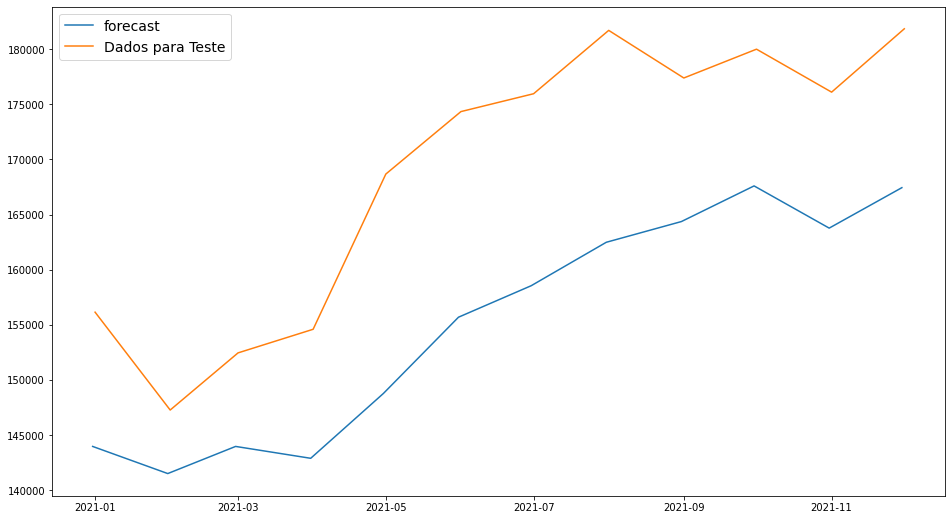

In [ ]:
plt.figure(figsize = (16, 9))

plt.plot(forecast_serie, label = 'forecast')
plt.plot(TestDataFrame, label = 'Dados para Teste')
plt.legend(loc = 'upper left', prop = {'size': 14})

plt.show()

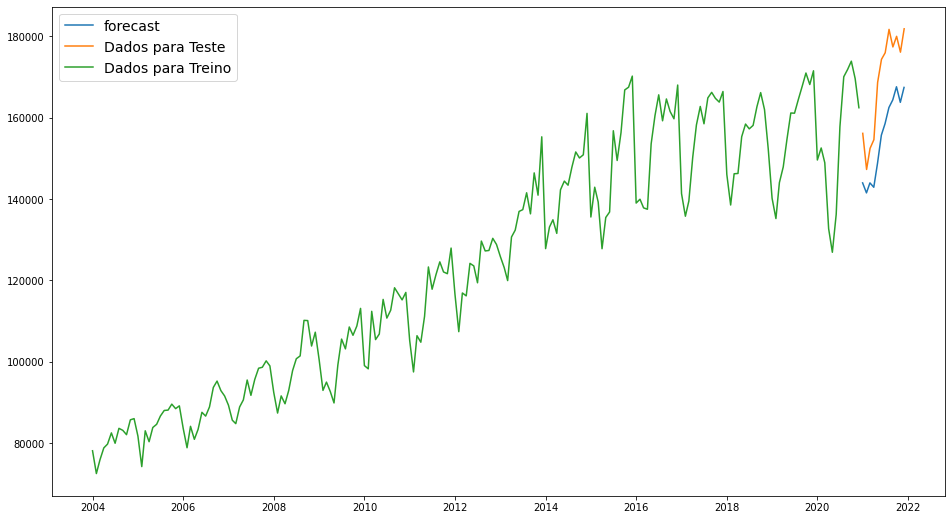

In [ ]:
plt.figure(figsize = (16, 9))

plt.plot(forecast_serie, label = 'forecast')
plt.plot(TestDataFrame, label = 'Dados para Teste')
plt.plot(TrainDataFrame, label = 'Dados para Treino')
plt.legend(loc = 'upper left', prop = {'size': 14})

plt.show()

# **Projeção para 12 meses/ 1 ano a frente**

In [ ]:
predição = modelmul.make_future_dataframe(serieNova, periods = 12)
prediçãofinal = modelmul.predict(predição)
prediçãofinal

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.204% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M
INFO - (NP.df_utils._infer_frequency) - Major frequency M corresponds to 83.333% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - M


,ds,y,yhat1,residual1,trend,season_yearly
0,2021-12-31,None,143858.609375,NaN,155100.703125,-0.136047
1,2022-01-31,None,141452.687500,NaN,155089.031250,-0.165045
2,2022-02-28,None,143728.671875,NaN,155078.500000,-0.137387
3,2022-03-31,None,142885.500000,NaN,155066.812500,-0.147473
4,2022-04-30,None,148422.343750,NaN,155055.515625,-0.080316
5,2022-05-31,None,155670.281250,NaN,155043.843750,0.007586
6,2022-06-30,None,158205.906250,NaN,155032.546875,0.038434
7,2022-07-31,None,162489.640625,NaN,155020.875000,0.090471
8,2022-08-31,None,164004.562500,NaN,155009.203125,0.108979
9,2022-09-30,None,167631.843750,NaN,154997.906250,0.153081


In [ ]:
prediçãofinall = prediçãofinal[['ds','yhat1']].set_index('ds').squeeze()
serie = serieNova[['ds','y']].set_index('ds').squeeze()


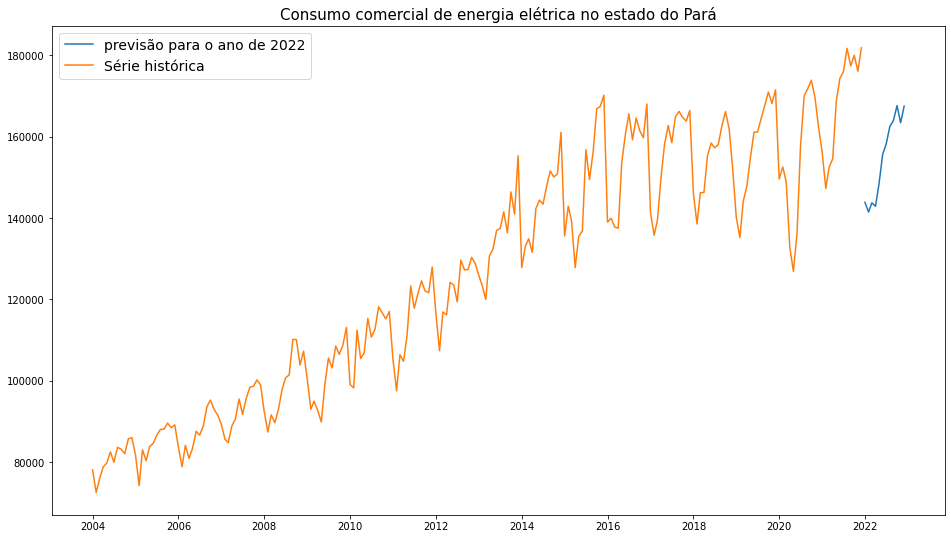

In [ ]:
plt.figure(figsize = (16, 9))

plt.plot(prediçãofinall, label = 'previsão para o ano de 2022')
plt.plot(serie, label = 'Série histórica')
plt.legend(loc = 'upper left', prop = {'size': 14})
plt.title('Consumo comercial de energia elétrica no estado do Pará',fontsize=15)

plt.show()

https://blog.katastros.com/a?ID=d5e2e8a8-e971-4db9-a5b0-e8f1dc592e89